# Phase linking basics

In this notebook, we will walk through the basic theory of phase linking. Here we aim to give a practical intuition by building a minimum working example; see [(Tebaldini, 2010)](https://www.intechopen.com/chapters/10403) for a complete overview with fuller mathematical treatment.

Our roadmap looks like

1. Create synthetic SLCs with decorrelation noise
2. Visualize the true coherence matrix
3. Build a sample coherence from a window of data
4. Apply the EVD (CAESAR) phase linking algorithm

We'll create a synthetic stack of SLCs using the [`synth`](https://github.com/opera-adt/synth) library and write the basic functions to perform phase linking.
Then we will view the results and compare the quality to simple multi-looked interferograms.

## Creating synthetic SLCs

We can install `synth-insar` using pip. We have provided a sample configuration JSON file, `synth_config.json`, which can be run on the command line with the following command:
```bash
synth-run --file synth_config.json
```
First, let's make the synthetic SLCs using the `synth` library. 

In [4]:
# If running in a kernel without the dependencies, run:
# !pip install synth-insar rich "numpy<2.3" matplotlib rasterio

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rich
from numpy.typing import ArrayLike
from rich import pretty

pretty.install()
%matplotlib inline

In [2]:
from synth.config import SimulationInputs
from synth.core import create_simulation_data

synth_config = SimulationInputs.model_validate_json(
    Path("synth_config.json").read_text()
)
rich.print(synth_config.custom_covariance)

CustomCoherence(gamma_inf=0.0, tau0=60.0, gamma0=1.0, seasonal_A=None, seasonal_B=None)

In [3]:
if not Path("synthetic-demo/slcs").exists():
    with open("synth_config.json") as f:
        inputs = SimulationInputs.model_validate_json(f.read())
    create_simulation_data(inputs)

To see what the coherence looks like that we are simulating, we can plot the "true" coherence matrix:

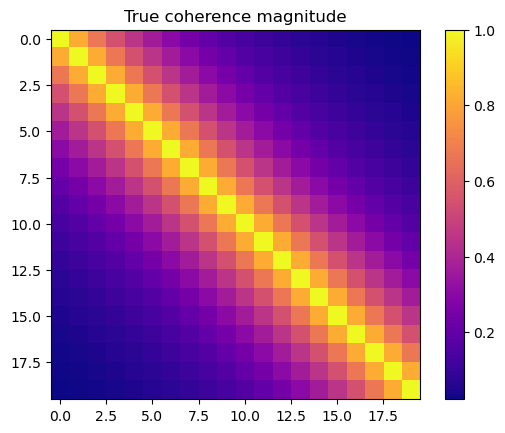

In [4]:
true_coherence = synth_config.get_custom_covariance_array()
fig, ax = plt.subplots()
axim = ax.imshow(np.abs(true_coherence), cmap="plasma")
ax.set_title("True coherence magnitude")
fig.colorbar(axim);

## Inspect the simulated data

Let's make some interferograms to see what the data looks like.
We'll form interferograms by performing a boxcar averaging with (11, 11) looks.

In [5]:
slc_file_list = sorted(Path("synthetic-demo/slcs").glob("2*.tif"))
print(f"Found {len(slc_file_list)} SLCs")


Found 20 SLCs

In [6]:
def take_looks(arr: ArrayLike, row_looks: int, col_looks: int) -> np.ndarray:
    """Downsample a numpy matrix by averaging blocks of (row_looks, col_looks).

    Parameters
    ----------
    arr : np.array
        2D array of an image
    row_looks : int
        the reduction rate in row direction
    col_looks : int
        the reduction rate in col direction

    Returns
    -------
    ndarray
        The downsampled array, shape = floor(rows / row_looks, cols / col_looks)

    Notes
    -----
    Cuts off values if the size isn't divisible by num looks.

    """
    if row_looks == 1 and col_looks == 1:
        return arr

    arr = np.asanyarray(arr)
    # Make the output shape divisible by the looks
    rows, cols = arr.shape
    row_cutoff = rows % row_looks
    col_cutoff = cols % col_looks
    if row_cutoff != 0:
        arr = arr[:-row_cutoff, :]
    if col_cutoff != 0:
        arr = arr[:, :-col_cutoff]

    rows, cols = arr.shape
    new_rows = rows // row_looks
    new_cols = cols // col_looks

    with warnings.catch_warnings():
        # ignore the warning about nansum of empty slice
        warnings.simplefilter("ignore", category=RuntimeWarning)
        return np.nanmean(
            np.reshape(arr, (new_rows, row_looks, new_cols, col_looks)), axis=(3, 1)
        )


def read_file(filename: Path | str, band: int = 1) -> np.ndarray:
    """Read in a raster as a numpy array."""
    with rio.open(filename) as src:
        return src.read(band)

In [7]:
def make_ifg(idx1: int, idx2: int, looks: tuple[int, int] = (11, 11)) -> np.ndarray:
    """Create an interferogram between slc indexes `idx1` and `idx2`."""
    # Load complex images
    s1 = np.squeeze(read_file(slc_file_list[idx1]))
    s2 = np.squeeze(read_file(slc_file_list[idx2]))

    # Unnormalized interferogram
    raw_ifg = s1 * np.conj(s2)
    # Apply looks to interferogram and power
    ifg = take_looks(raw_ifg, *looks)
    pow1 = take_looks(s1 * np.conj(s1), *looks)
    pow2 = take_looks(s2 * np.conj(s2), *looks)
    # Normalize by coherence
    ifg = ifg / np.sqrt(pow1 * pow2)
    return ifg

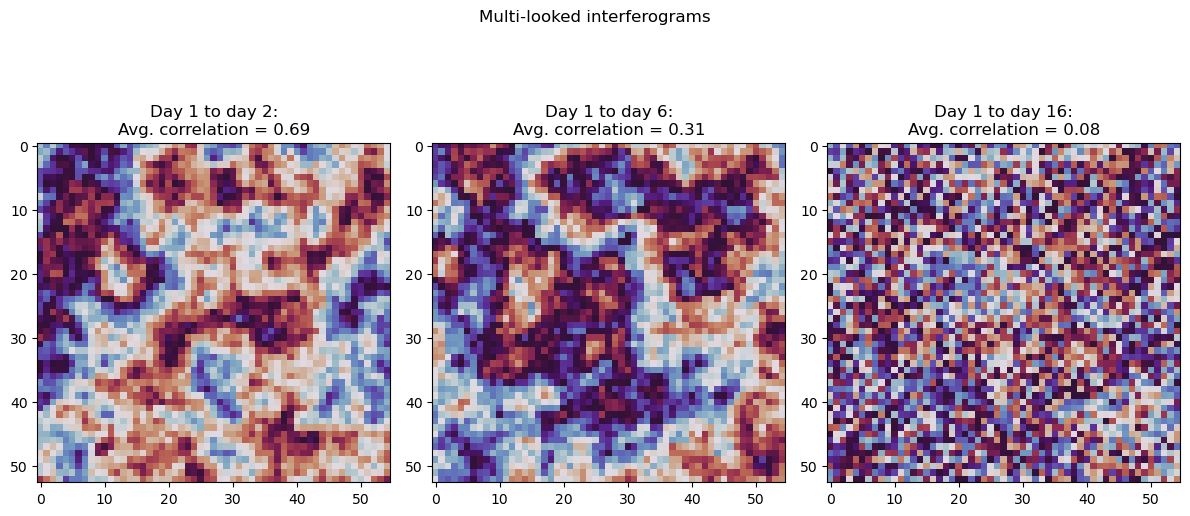

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
kw = {
    "vmin": -np.pi,
    "vmax": np.pi,
    "cmap": "twilight_shifted",
    "interpolation": "nearest",
}

for ax, n in zip(axes, [1, 5, 15], strict=False):
    ifg_0_n = make_ifg(0, n)
    title = f"Day 1 to day {n+1}:\n"
    title += f"Avg. correlation = {np.nanmedian(np.abs(ifg_0_n)):.2f}"
    ax.imshow(np.angle(ifg_0_n), **kw)
    ax.set_title(title)

fig.suptitle("Multi-looked interferograms")
fig.tight_layout();

So after just 15 images, the normal multilooked interferograms look completely decorrelated (note that very low correlations will always be skewed upwards).

## Intuition on phase linking
There are many ways to describe the motivation and goals of phase linking:

1. **Making a group of distributed scatterers (DS) pixels behave like a persistent scatterer (PS)**.
PS pixels are usually described as pixels which contain a strong reflecting source (e.g., a building or corner reflector). These pixels show low noise at the native, full SAR resolution. DS pixels show more noise, and they generally require averaging (multi-looking) to trade lower resolution for better performance.

2. **Optimally using all interferograms**.
InSAR processing of multi-looked interferograms often discards interferograms with low coherence through arbitrary thresholding (e.g., throwing away any interferogram with average coherence < 0.3). This is wasteful because even low-coherence interferograms contain some useful information about the phase history.

3. **Solving the phase misclosure problem**.
When multi-looked interferograms are formed between three dates (say `A`, `B`, and `C`), then the phase from interferograms `A→B` and `B→C` does not add up to the phase from interferogram `A→C` due to noise and scattering changes (e.g., soil moisture). By finding one consistent phase history, phase linking solves this inconsistency problem in the wrapped-phase domain before phase unwrapping occurs.


## Phase linking in X lines of Python

Here we will write out the simplest form of phase linking in Python in as few lines as possible:

### 1. Read in a block of SLC pixels

Get SLC samples into an array of shape (`nslc`, `num_samples`). 
The `num_samples` is the "number of looks" we perform when making all possible multilooked interferograms.

In [9]:
all_slc_data = np.stack([read_file(f) for f in slc_file_list])
nslc, nrows, ncols = all_slc_data.shape
print("Size of SLC stack:")
print(all_slc_data.shape)

Size of SLC stack:

(20, 592, 609)

In [10]:
half_row, half_col = (5, 5)

# Pick a row and column to process
row, col = 100, 100
sub_stack = all_slc_data[
    :, row - half_row : row + half_row + 1, col - half_col : col + half_col + 1
]
slc_samples = sub_stack.reshape(nslc, -1)
print(sub_stack.shape, slc_samples.shape)

(20, 11, 11)
(20, 121)

### 2. Form the coherence matrix, $T \in \mathbb{C}^{N\times N}$ of all possible interferogrms.

The $m,n$ th element of this matrix is $\rho_{m,n}\exp (j \cdot \phi_{m,n})$, where $\rho_{m,n}$ correlation magnitude of the interferogram between image $m$ and image $n$, and $\phi_{m,n}$ is the interferometric phase.

In [11]:
def compute_sample_coherence(slc_samples: np.ndarray) -> np.ndarray:
    """Compute an estimate of the coherence matrix from `slc_samples`.

    The input shape of `slc_samples` is (number of slcs, number of samples).
    """
    # Compute un-normalized interferogram, the numerator of the complex correlation
    ifgs = np.dot(slc_samples, np.conj(slc_samples.T))

    # Compute amplitudes so we normalize the covariance to a coherence matrix
    # amp_vec is shape (nslc,)
    amp_vec = np.sum(np.abs(slc_samples) ** 2, axis=1)

    # Form outer product of amplitudes for each slc to get an (N, N) power matrix
    powers = amp_vec[:, None] * amp_vec[None, :]
    amplitudes = np.sqrt(powers)

    # Compute coherence matrix
    coherence = ifgs / amplitudes

    # recommended: Make the output 0 where the amplitudes are 0,
    # rather than dividing by zero, like
    # coherence = np.where(amplitudes > 1e-6, coherence, 0 + 0j)
    return coherence

In [12]:
coherence = compute_sample_coherence(slc_samples)
print(coherence.shape, coherence.dtype)

(20, 20)
complex64

Let's plot the coherence matrix for this pixel:

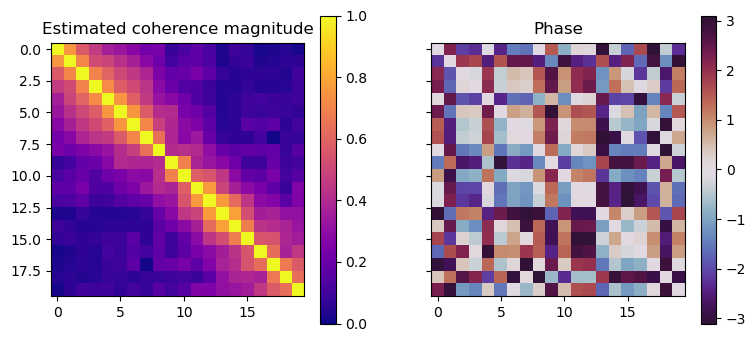

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)
axim = axes[0].imshow(np.abs(coherence), vmax=1, vmin=0, cmap="plasma")
fig.colorbar(axim, ax=axes[0])
axim = axes[1].imshow(np.angle(coherence), cmap="twilight_shifted")
fig.colorbar(axim, ax=axes[1])

axes[0].set_title("Estimated coherence magnitude")
axes[1].set_title("Phase");

### 3. Optimize the coherence matrix to get a phase vector

There are many "coherence optimization algorithms" [@Ansari2018EfficientPhaseEstimation].

Here we pick the simplest to implement: "EVD", also known as "CAESAR" in [@Fornaro2015CAESARApproachBased]

The idea is the same as [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis): we take the largest eigenvector.

(That is, compute the eigenvectors and eigenvalues of the coherence matrix, then use the eigenvector corresponding the largest eigenvalue)

In [14]:
from scipy.linalg import eigh  # Hermitian eigenvalue function from scipy


def largest_eigenpair(T) -> tuple[float, np.ndarray]:
    """Get the largest eigenvalue for the "EVD / CAESAR" method."""
    nslc = T.shape[-1]
    lambda_, eig_vecs = eigh(T, subset_by_index=[nslc - 1, nslc - 1])
    return lambda_[-1], eig_vecs[:, -1]


def link_phases_evd(T) -> np.ndarray:
    """Compute the EVD phase linking solution for coherence matrix `T`."""
    _eig_vals, eig_vecs = largest_eigenpair(T)
    # One note: Since we are working with "phase differences", there is an arbitrary
    # phase offset in the solution vector.
    # So, we must pick some index and use that as the "reference".
    # Reference the phases to the first element to remove the arbitrary offset
    # (follow convention of `reference * secondary.conj()`)
    eig_vecs = eig_vecs[0] * eig_vecs.conj()
    return np.angle(eig_vecs)


In [15]:
optimized_phase = link_phases_evd(coherence)
print(optimized_phase.shape)
print(optimized_phase.dtype)

(20,)

float32

After running this on every pixel, the result will be a set of single-reference interferograms.

In [16]:
output = np.zeros((nslc, nrows, ncols), dtype="float32")
# We could do index arithmetic to skip outputs and speed it up greatly:
# for row in range(half_row, (nrows - half_row)//skip_every, skip_every):
# for col in range(half_col, (ncols - half_col)//skip_every, skip_every):
# For now, just run at full output posting

for row in range(half_row, output.shape[1] - half_row):
    for col in range(half_col, output.shape[2] - half_col):
        cur_stack = all_slc_data[
            :, row - half_row : row + half_row + 1, col - half_col : col + half_col + 1
        ]
        cur_coherence = compute_sample_coherence(cur_stack.reshape(nslc, -1))
        cur_output = link_phases_evd(cur_coherence)

        output[:, row, col] = cur_output


## Plot the phase linking results

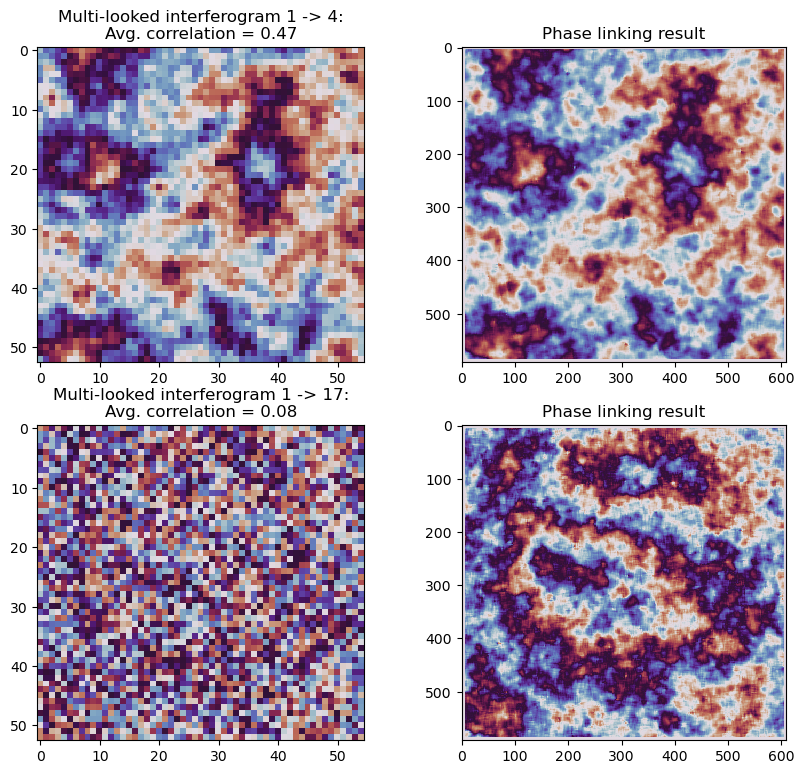

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
kw = {
    "vmin": -np.pi,
    "vmax": np.pi,
    "cmap": "twilight_shifted",
    "interpolation": "nearest",
}

for (ax1, ax2), n in zip(axes, [3, 16], strict=False):
    ifg_0_n = make_ifg(0, n)
    title = f"Multi-looked interferogram 1 -> {n+1}:\n"
    title += f"Avg. correlation = {np.nanmedian(np.abs(ifg_0_n)):.2f}"
    ax1.imshow(np.angle(ifg_0_n), **kw)
    ax1.set_title(title)

    ax2.imshow(output[n], **kw)
    ax2.set_title("Phase linking result")

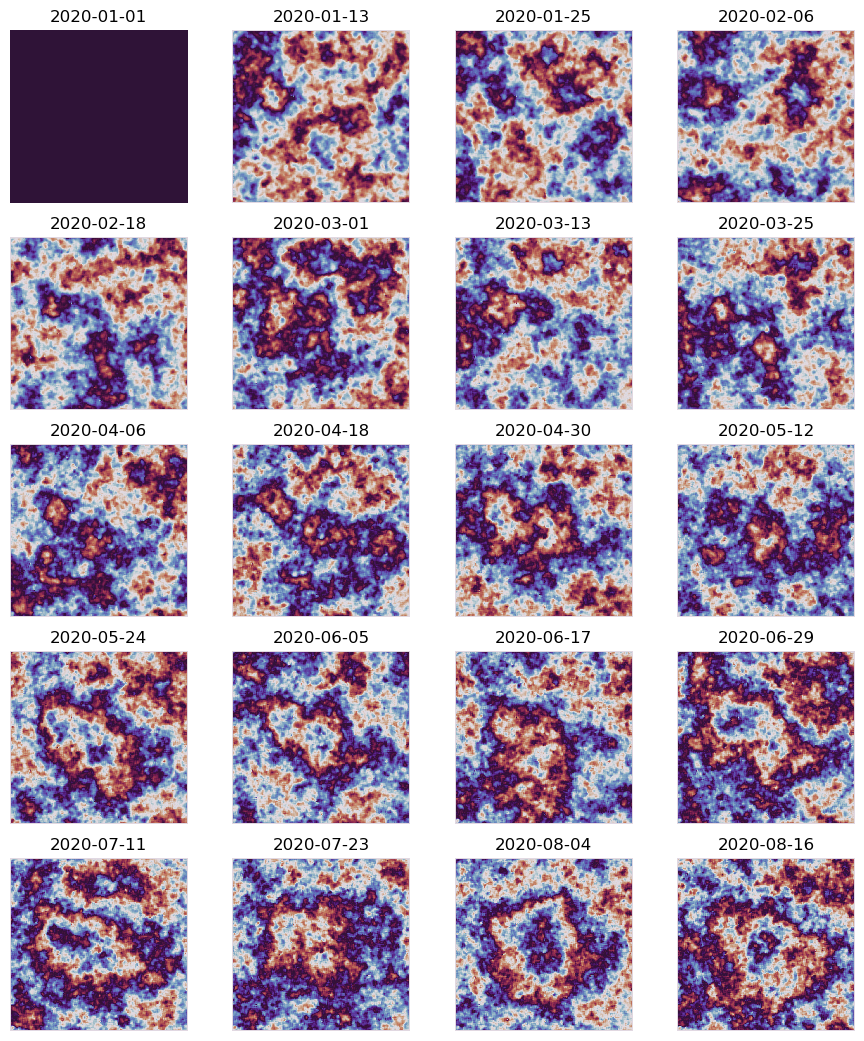

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(11, 13))
for ax, d, phase in zip(axes.ravel(), synth_config.datetimes, output, strict=False):
    ax.imshow(phase, cmap="twilight_shifted", interpolation="nearest")
    ax.set_title(d.strftime("%Y-%m-%d"))
    ax.set_axis_off()

We see that the phase linking results in coherent phases until the end of the stack.